# Customer Review Clustering using TF-IDF and K-means

One of the greatest assets for continuing improvement of a business is customer reviews. For example, reviews can help acknowledge the successes of the business while illuminating areas of potential development. The task is easy when there are few reviews. However when there are many reviews and many more continuously being submittted, this becomes a seemingly insurmountable task. This is where automation and machine learning is crucial.

Our goal for this project is to take all reviews availible on yelp and cluster these customers into like-minded groups. From there, we will condense their reviews into significant information for quick analysis. Using the significant information, the most impactful issues are highlighted and business improvement plans can be developed.

Here we will utilize BeautifulSoup's webscraping capabilities to gather all reviews for subsequent analysis. The reviews will be preprocessed to reduce noise within the data. The processed data will be converted to comparable numerical quantities using the TF-IDF algorithm. These numerical quantities will be clustered using the K-means algorithm. Lastly, the results will be presented using seaborn's plotting prowess and by displaying top keywords within each cluster.

### Webscrape Reviews
Our goal is to create a function that scrapes the page of a yelp business with relatively few parameters: the main url of the yelp business and the total number of review pages. Once the reviews are gathered, they can be stored as a csv for future clustering and analysis. Since the time between new reviews being poster is large, there is no need to the webscraping to be automated during this time. In this case, we will gather 359 reviews from a local japanese restaurant.

In [8]:
# library
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import os

In [9]:
# Webscraping class
class yelp_web_scrape():
    '''scrapes reviews from yelp for desired business
    '''
    def __init__(self):
        self.reviews = []
        
    def url_all_pages(self, main_url, num_total_pages):
        """creates an array of url strings for all review pages
        
        parameters
        ==========
        main_url: String
            url of the main yelp page for restaurant
        
        num_total_pages: int
            number of total pages of reviews
        """
        urls = [main_url]
        for i in range(num_total_pages-1):
            x = (i+1)*10
            urls.append(main_url + "?start=%d" %x)
        return urls
    
    def scrape(self, url):
        """retrieves data from yelp
        
        Parameters
        ==========
        url: String
            url of the site to be scraped
        """
        if isinstance(url, str) == True:
            # makes a request to the site
            page = requests.get(url)
            # check to see if the request was successful
            if page.ok:
                #get reviews from site
                soup = BeautifulSoup(page.content, "html.parser")
                body = soup.find(id = "yelp_main_body")
                wrap = body.find(class_ = "main-content-wrap main-content-wrap--full")
                border = wrap.find_all(class_ = "comment__373c0__1M-px css-n6i4z7")
                texts = [text.get_text() for text in border]
                for text in texts:
                    self.reviews.append(text)
                    
    def write_csv(self):
        """Writes a csv file so there is no need to scrape everytime
        """
        df = pd.DataFrame(self.reviews)
        if not os.path.exists('yelp_reviews.csv'):
            df.to_csv("yelp_reviews.csv", mode = "w+")
            print("File saved as: yelp_reviews.csv")
        
    def load_csv(self):
        """Loads the previously saved csv file
        """
        temp = pd.read_csv("yelp_reviews.csv", names = ["id","review"]).drop(axis=0, index=0)
        temp_id = temp["id"].round(0).astype(int)
        temp_review = temp["review"]
        self.reviews = pd.DataFrame({'id' : temp_id, 'review': temp["review"]})
        print("File has been loaded")

In [6]:
# parameters
start_url = "https://www.yelp.com/biz/little-katana-las-colinas-irving-3"
pages = 36

# get url strings for pages
yelp = yelp_web_scrape()
urls = yelp.url_all_pages(start_url, pages)

# scrape the reviews from pages
i = 0
for url in urls:
    i += 1
    yelp.scrape(url)
    if i % 5 == 0 or i == pages:
        print("Progress: %d/%d" %(i, pages))

print("\nCompleted: Loaded %d reviews"%len(yelp.reviews))

Progress: 5/36
Progress: 10/36
Progress: 15/36
Progress: 20/36
Progress: 25/36
Progress: 30/36
Progress: 35/36
Progress: 36/36

Completed: Loaded 359 reviews


In [15]:
# create a csv file to continue development
yelp.write_csv()

File saved as: yelp_reviews.csv


In [17]:
# Load the data here after the 1st initial save_csv
yelp_webscrape = yelp_web_scrape()
yelp_webscrape.load_csv()
data = yelp_webscrape.reviews
data.head()

File has been loaded


,id,review
1,0,Couldn't decide on a place originally and some...
2,1,I just noticed Little Katana recently as I was...
3,2,Let me start with -- wow. This is amazing. The...
4,3,Best sushi in town and service was so amazing....
5,4,Really impressed by the quality of the sushi h...


### Preprocessing data
Not only is the english language extremely complex, but things written by humans tend to be messy. These insights highlight the necessity of data preprocessing to produce clean and coherent data to machines. Firstly, english is riddled with contractions and punctuations which makes it difficult to differentiate between words while potentially including redundencies. So, those are removed. Numbers are removed as well since they have little significance in this case. Second, the reviews were tokenized to be used in the TF-IDF algorithm. Both stemming and lemmatization procedures were considered, but increased the sum of squares error (SSE) when implemented. So, these steps were ommitted. Lastly, the words underwent the stop word removal and TF-IDF where only the top 50 words with a document frequency of a minimum of 5.0 was considered. The resulting TF-IDF array was normalized to eliminate variance discrepancies among different words which could affect the subsequent K-means algorithm.

In [19]:
# function to replace contractions
import re
from nltk.corpus import wordnet

R_patterns = [
   (r'won\'t', 'will not'),
   (r'can\'t', 'cannot'),
   (r'i\'m', 'i am'),
   (r'(\w+)\'ll', '\g<1> will'),
   (r'(\w+)n\'t', '\g<1> not'),
   (r'(\w+)\'ve', '\g<1> have'),
   (r'(\w+)\'s', '\g<1> is'),
   (r'(\w+)\'re', '\g<1> are'),
]

class REReplacer(object):
    """expands contractions of string inputs

    Parameters
    ==========
    patterns: list of strings
        list of contraction substitutions
    """
    def __init__(self, patterns = R_patterns):
        self.pattern = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        """expands the contractions matching the pre-registered patterns in the string input
        
        Parameters
        ==========
        text: string
            text that has contractions
        """
        s = text
        for (pattern, repl) in self.pattern:
            s = re.sub(pattern, repl, s)
        return s

In [20]:
# replace contractions
rep_word = REReplacer()

no_concat = []
for row in yelp_webscrape.reviews["review"]:
    #no_concat.append(rep_word.replace(row))
    no_concat.append(rep_word.replace(row))
    
data["text_no_conctraction"] = no_concat
data.head()

,id,review,text_no_conctraction
1,0,Couldn't decide on a place originally and some...,Could not decide on a place originally and som...
2,1,I just noticed Little Katana recently as I was...,I just noticed Little Katana recently as I was...
3,2,Let me start with -- wow. This is amazing. The...,Let me start with -- wow. This is amazing. The...
4,3,Best sushi in town and service was so amazing....,Best sushi in town and service was so amazing....
5,4,Really impressed by the quality of the sushi h...,Really impressed by the quality of the sushi h...


In [21]:
# function to remove punctuations and numbers
import re
import string
def preprocessing(line):
    '''replaces punctuation and numbers with spaces
    
    Parameters
    ==========
    line: string
        string that needs to be cleaned 
    '''
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
        # substitutes punctuations for spaces
    line = re.sub(r"[0-9]", " ", line)
    return line

In [22]:
# tokenizing and stemming step - Not Used
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
lemma = nltk.wordnet.WordNetLemmatizer()
def tokenize_and_stem(text):
    """first tokenize, then reduces words to their stems
    
    Parameters
    ==========
    text: string
        text input
    """
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g. numeric tokens, raw punctuations)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# lemmatization - used because it is more comprehensible
def tokenize_and_lemma(text):
    """first tokenize, then reduces words to their lemmas
    
    Parameters
    ==========
    text: string
        text input
    """
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g. numeric tokens, raw punctuations)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemmas = [lemma.lemmatize(t) for t in filtered_tokens]
    return lemmas

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
tfidf_vectorizer = TfidfVectorizer(
    preprocessor = preprocessing,
    # tokenizer = tokenize_and_lemma,
    min_df = 5,
    max_df = 0.95,
    max_features = 50,
    stop_words = "english"
)
tfidf = tfidf_vectorizer.fit_transform(data.text_no_conctraction)
tf_idf_norm = normalize(tfidf) # eliminates varaince differences
tf_idf_array = tf_idf_norm.toarray()

In [24]:
# view the tf-idf array for selected words
display(pd.DataFrame(tf_idf_array, columns=tfidf_vectorizer.get_feature_names()).head())

,amazing,area,bar,best,bowl,came,come,definitely,delicious,did,...,rolls,salmon,service,spicy,staff,stone,sushi,time,try,tuna
0,0.000000,0.071732,0.0,0.000000,0.0,0.279209,0.000000,0.0,0.0,0.066763,...,0.0,0.714442,0.085872,0.000000,0.000000,0.0,0.070099,0.0,0.000000,0.000000
1,0.000000,0.214267,0.0,0.000000,0.0,0.208503,0.212781,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.215785,0.0,0.104695,0.0,0.201902,0.000000
2,0.280848,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.342004,0.000000,0.000000,0.000000,0.0,0.151005,0.0,0.000000,0.000000
3,0.199617,0.000000,0.0,0.200794,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.131478,0.459079,0.000000,0.0,0.107329,0.0,0.000000,0.245244
4,0.311018,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.501679,0.0,0.000000,0.000000


In [25]:
# view the selected words for tf-idf
" ".join(tfidf_vectorizer.get_feature_names())

'amazing area bar best bowl came come definitely delicious did dinner fish food fresh friendly good got great happy hot hour just katana like little love lunch menu nice night order ordered place quality ramen really recommend restaurant rice roll rolls salmon service spicy staff stone sushi time try tuna'

## Find the Optimal number of clusters
The most important hyperparameter for our K-means algorithm is the number of clusters (k) that we want. The optimal number of clusters will be estimated through the use of the elbow method. Below, the sum of squares error (SSE) is plotted and it will be assumed that 30 clusters is optimal. 

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def find_optimal_cluster(data, max_k):
    iters = range(2, max_k+1, 2) # increases the number of clusters by 2
    sse = []
    
    for k in iters:
        sse.append(KMeans(n_clusters = k, random_state = 20, max_iter = 1000, algorithm = "auto").fit(data).inertia_)
            # init_size and batch_size can be changed later when more data is availible
            # MiniBatch speeds up KMeans algo, but still needs all the necessary memory to hold data
        print("Fit {} clusters".format(k)) # prints k in brackets
    
    # ploting details
    f, ax = plt.subplots(1,1)
    ax.plot(iters, sse, marker = "o")
    ax.set_xlabel("Cluster Centers")
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel("SSE")
    ax.set_title("SSE by Cluster Center Plot")   

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


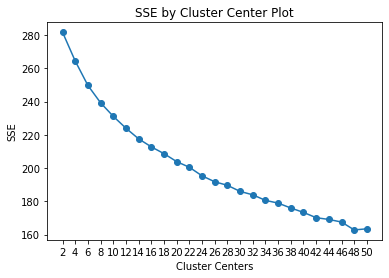

In [27]:
# call function
find_optimal_cluster(tf_idf_array, 50)

# right now 30 clusters seem optimal
clusters = KMeans(n_clusters=30, random_state = 20, max_iter = 600, algorithm = "auto").fit_predict(tf_idf_array)

## Plot Cluster
The created clusters will be represented through T-SNE. This technique allows for clear seperation through condensation of PCA's multiple components down to a 2 dimensional representation. This bypasses PCA's issue of limited explained variance which results in an L-shaped plot. For this case, we will use 50 principal components.

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

def plot_tsne(data, labels):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plot_data = pd.DataFrame({"x": tsne_results[:,0], "y": tsne_results[:,1], "Cluster": labels})
    
    # plot details
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x = "x", y = "y",
        hue = "Cluster",
        palette=sns.color_palette("hls", len(plot_data.Cluster.unique())),
        data = plot_data,
        legend = "full",
        alpha = 0.8
    )
    plt.title("T-SNE Plot")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 359 samples in 0.005s...
[t-SNE] Computed neighbors for 359 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 359 / 359
[t-SNE] Mean sigma: 0.389553
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.864304
[t-SNE] KL divergence after 300 iterations: 1.472784


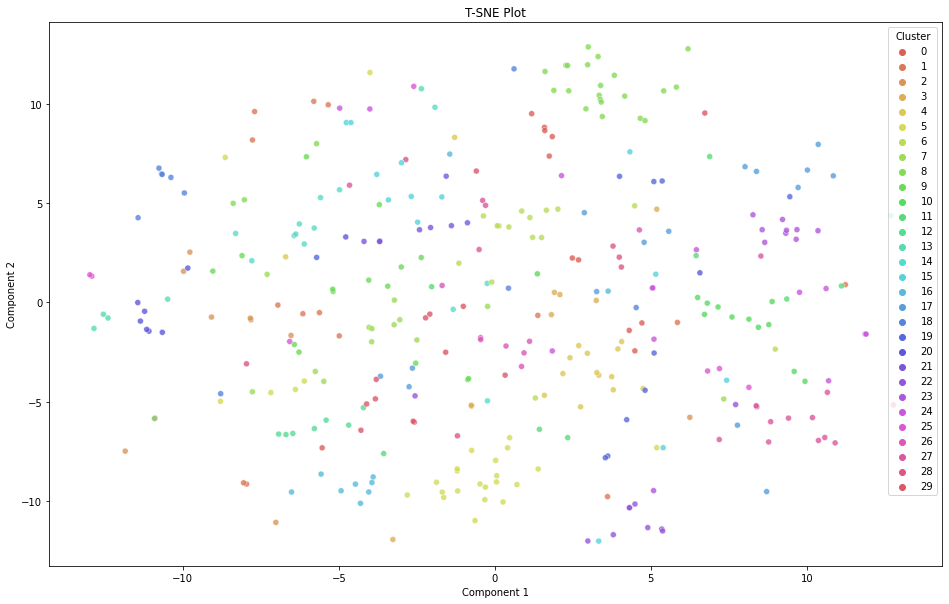

In [29]:
plot_tsne(tf_idf_array, clusters)

### Top Keywords
Within each cluster, the number of members and the 10 words with the highest TF-IDF score is presented below. Most of the clusters agree that the restaurant is splendid.

In [30]:
# function
def get_top_keywords(data, cluster, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    (unique, counts) = np.unique(cluster, return_counts=True)
    
    for i,r in df.iterrows():
        print("\nCluster %d: %d members" %(i, counts[i]))
        print(",".join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [31]:
get_top_keywords(tf_idf_array,clusters,tfidf_vectorizer.get_feature_names(),10)


Cluster 0: 11 members
definitely,katana,hot,roll,stone,food,service,time,best,amazing

Cluster 1: 14 members
restaurant,amazing,food,did,place,delicious,sushi,good,fresh,come

Cluster 2: 9 members
really,dinner,time,katana,definitely,good,menu,little,order,lunch

Cluster 3: 8 members
just,rolls,restaurant,sushi,time,best,place,food,night,nice

Cluster 4: 15 members
little,quality,try,sushi,amazing,love,food,service,place,great

Cluster 5: 27 members
good,nice,really,place,service,food,sushi,great,hour,happy

Cluster 6: 15 members
fresh,best,katana,really,restaurant,good,just,sushi,ordered,roll

Cluster 7: 14 members
little,menu,fresh,great,roll,nice,rolls,service,sushi,good

Cluster 8: 25 members
good,place,ordered,great,delicious,food,rice,hot,stone,bowl

Cluster 9: 15 members
little,katana,sushi,nice,fresh,good,really,roll,staff,friendly

Cluster 10: 12 members
amazing,spicy,tuna,did,food,good,sushi,place,like,just

Cluster 11: 8 members
good,got,like,bar,came,sushi,did,try,time,pla

### Improvements

##### Webscraping:
1. Having more data (demographic data, dates, ratings, ect.) would allows for more interesting data exploration insights and more diverse features to improve cluster seperations. 
2. Additionally if this model would be applied to a large business with a steady stream of customer reviews, automatization and model refitting would be crucial towards gaining accurate insights at an acceptable speed. 
3. Lastly, there was significant cluster overlap because most of the reviews were positive. This model would be best suited for reviews with more diverse sentiments and opinions.

##### Preprocessing
1. People tend to stack a lot of information about a different aspects of a business in a review. It is hard to cluster a multifaceted review since it is similar to many other documents due to its diverse nature. To combat this, a potential solutiion would be to seperate the review by sentences and cluster the sentences instead.
2. Once there is more data, I would implement lemmatization in the preprocessing step to reduce redundencies. 
3. The model had a slow drop-off in SSE as the number of clusters increased. Different algorithms should be texted (e.g. ELMo BERT) to see if better results and seperation can be achieved.

##### Clustering
1. More data would improve clustering seperation. 
2. Again, more diverse data would improve cluster seperation. 

##### Top Keywords
1. I would include a bargraph that compares the number of uses of the top words in each cluster. However, this would only work if there is a smaller number of clusters
2. Furthermore, displaying the review closest to the cluster center would offer more insight into the general opinion of the cluster